<a href="https://colab.research.google.com/github/MaxKwen2/LSTM-Code/blob/main/BCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0071 - val_loss: 0.0029
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.7098e-04 - val_loss: 0.0028
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3948e-04 - val_loss: 0.0018
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.7795e-04 - val_loss: 0.0021
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.0734e-04 - val_loss: 0.0010
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.8757e-04 - val_loss: 0.0021
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7253e-04 - val_loss: 9.1010e-04
Epoch 8/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9739e-04 - val_loss: 7.9149e-04
Epoch 9/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.2277e-04 - val_loss: 4.6721e-04
Epoch 10/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.5145e-04 - val_loss: 4.3928e-04
Epoch 11/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.5719e-04 - va

<function __main__.predict_n_days(model_path, df, n_days=7)>

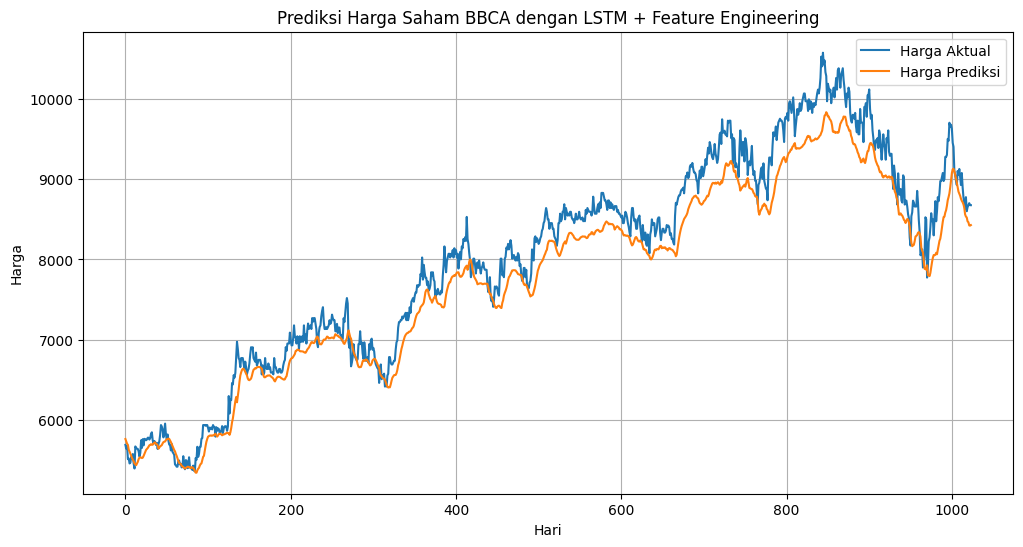

In [ ]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def predict_n_days(model_path, df, n_days=7):
    model = load_model(model_path)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['Close']])
    last_seq = scaled[-60:].tolist()
    predictions = []

    for _ in range(n_days):
        input_seq = np.array(last_seq[-60:]).reshape((1, 60, 1))
        pred_scaled = model.predict(input_seq)
        predictions.append(float(scaler.inverse_transform(pred_scaled)[0][0]))
        last_seq.append(pred_scaled[0])  # Gunakan prediksi sebagai input selanjutnya

    return predictions


df = pd.read_csv("/content/drive/MyDrive/DS/dataBCA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# STEP 3: Feature Engineering
df['return_1d'] = df['Close_BBCA.JK'].pct_change()
df['ma_5'] = df['Close_BBCA.JK'].rolling(window=5).mean()
df['ma_10'] = df['Close_BBCA.JK'].rolling(window=10).mean()
df['ma_20'] = df['Close_BBCA.JK'].rolling(window=20).mean()
df['range'] = df['High_BBCA.JK'] - df['Low_BBCA.JK']
df['volume_z'] = (df['Volume_BBCA.JK'] - df['Volume_BBCA.JK'].rolling(20).mean()) / df['Volume_BBCA.JK'].rolling(20).std()

# Hapus nilai NaN hasil rolling
df.dropna(inplace=True)

# Pilih fitur dan target
features = ['Close_BBCA.JK', 'ma_10', 'range', 'volume_z']
target = 'Close_BBCA.JK'
data = df[features]

# Normalisasi
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# STEP 4: Membentuk window time series
def create_multivariate_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # kolom 0 = harga penutupan
    return np.array(X), np.array(y)

window_size = 60
X, y = create_multivariate_sequences(scaled_data, window_size)

# STEP 5: Split data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# STEP 6: Model LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# STEP 7: Prediksi
predicted = model.predict(X_test)

# Prediksi multiple days
display(predict_n_days)

# Gunakan kembali hanya skala harga penutupan
scaler_price = MinMaxScaler()
scaler_price.fit(df[['Close_BBCA.JK']])
predicted_prices = scaler_price.inverse_transform(predicted.reshape(-1, 1))
real_prices = scaler_price.inverse_transform(y_test.reshape(-1, 1))

# STEP 8: Visualisasi
plt.figure(figsize=(12,6))
plt.plot(real_prices, label='Harga Aktual')
plt.plot(predicted_prices, label='Harga Prediksi')
plt.title('Prediksi Harga Saham BBCA dengan LSTM + Feature Engineering')
plt.xlabel('Hari')
plt.ylabel('Harga')
plt.legend()
plt.grid()
plt.show()

Training: units=64, dropout=0.2, optimizer=adam, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 25637.7898
Training: units=64, dropout=0.2, optimizer=adam, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 43839.3066
Training: units=64, dropout=0.2, optimizer=rmsprop, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 24526.4070
Training: units=64, dropout=0.2, optimizer=rmsprop, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 39064.9014
Training: units=64, dropout=0.3, optimizer=adam, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 43633.2626
Training: units=64, dropout=0.3, optimizer=adam, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 175914.0854
Training: units=64, dropout=0.3, optimizer=rmsprop, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 25372.1075
Training: units=64, dropout=0.3, optimizer=rmsprop, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 155961.5502
Training: units=128, dropout=0.2, optimizer=adam, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 79212.6627
Training: units=128, dropout=0.2, optimizer=adam, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 75387.8580
Training: units=128, dropout=0.2, optimizer=rmsprop, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 23665.0443
Training: units=128, dropout=0.2, optimizer=rmsprop, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 54923.2152
Training: units=128, dropout=0.3, optimizer=adam, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 22974.0815
Training: units=128, dropout=0.3, optimizer=adam, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 171297.8494
Training: units=128, dropout=0.3, optimizer=rmsprop, layers=1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 34970.1157
Training: units=128, dropout=0.3, optimizer=rmsprop, layers=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


MSE: 38031.6942
Units=128, Dropout=0.3, Optimizer=adam, Layers=1, MSE=22974.0815
Units=128, Dropout=0.2, Optimizer=rmsprop, Layers=1, MSE=23665.0443
Units=64, Dropout=0.2, Optimizer=rmsprop, Layers=1, MSE=24526.4070
Units=64, Dropout=0.3, Optimizer=rmsprop, Layers=1, MSE=25372.1075
Units=64, Dropout=0.2, Optimizer=adam, Layers=1, MSE=25637.7898
Units=128, Dropout=0.3, Optimizer=rmsprop, Layers=1, MSE=34970.1157
Units=128, Dropout=0.3, Optimizer=rmsprop, Layers=2, MSE=38031.6942
Units=64, Dropout=0.2, Optimizer=rmsprop, Layers=2, MSE=39064.9014
Units=64, Dropout=0.3, Optimizer=adam, Layers=1, MSE=43633.2626
Units=64, Dropout=0.2, Optimizer=adam, Layers=2, MSE=43839.3066
Units=128, Dropout=0.2, Optimizer=rmsprop, Layers=2, MSE=54923.2152
Units=128, Dropout=0.2, Optimizer=adam, Layers=2, MSE=75387.8580
Units=128, Dropout=0.2, Optimizer=adam, Layers=1, MSE=79212.6627
Units=64, Dropout=0.3, Optimizer=rmsprop, Layers=2, MSE=155961.5502
Units=128, Dropout=0.3, Optimizer=adam, Layers=2, MSE=17

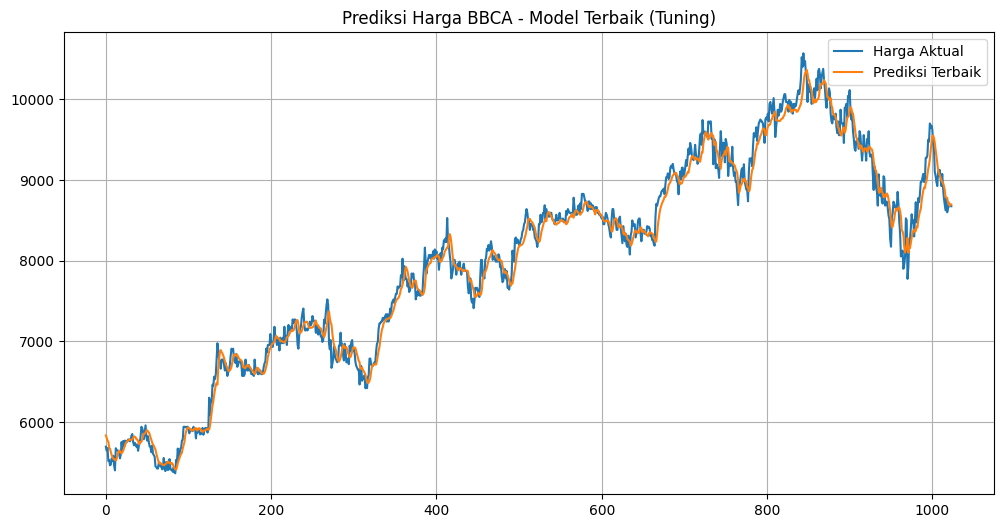

In [ ]:
# Lanjutan dari kode sebelumnya, setelah preprocessing & sequence siap
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import itertools

# Definisi grid parameter
neurons = [64, 128]
dropouts = [0.2, 0.3]
optimizers = ['adam', 'rmsprop']
layer_options = [1, 2]

results = []
best_model = None
best_mse = float('inf')

# Loop semua kombinasi parameter
for units, drop, opt, layers in itertools.product(neurons, dropouts, optimizers, layer_options):
    print(f"Training: units={units}, dropout={drop}, optimizer={opt}, layers={layers}")

    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(LSTM(units, return_sequences=(layers==2), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(drop))
    if layers == 2:
        model.add(LSTM(units))
        model.add(Dropout(drop))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    preds = model.predict(X_test)
    preds_rescaled = scaler_price.inverse_transform(preds.reshape(-1, 1))
    y_true_rescaled = scaler_price.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_true_rescaled, preds_rescaled)

    print(f"MSE: {mse:.4f}")
    results.append((units, drop, opt, layers, mse))

    if mse < best_mse:
        best_mse = mse
        best_model = model

# Tampilkan hasil tuning
sorted_results = sorted(results, key=lambda x: x[-1])
for res in sorted_results:
    print(f"Units={res[0]}, Dropout={res[1]}, Optimizer={res[2]}, Layers={res[3]}, MSE={res[4]:.4f}")

# Simpan model terbaik (opsional)
best_model.save("best_lstm_bbca.h5")

# Visualisasi hasil terbaik
best_pred = best_model.predict(X_test)
best_pred_rescaled = scaler_price.inverse_transform(best_pred.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(y_true_rescaled, label="Harga Aktual")
plt.plot(best_pred_rescaled, label="Prediksi Terbaik")
plt.title("Prediksi Harga BBCA - Model Terbaik (Tuning)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true_rescaled, best_pred_rescaled))
mape = mean_absolute_percentage_error(y_true_rescaled, best_pred_rescaled) * 100

print("RMSE:", rmse)
print("MAPE:", mape)


RMSE: 151.57203410001492
MAPE: 1.4503743273088037


In [ ]:
import joblib

joblib.dump(best_model, '/content/drive/MyDrive/DS/modelBCA.pkl')

['/content/drive/MyDrive/DS/modelBCA.pkl']

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


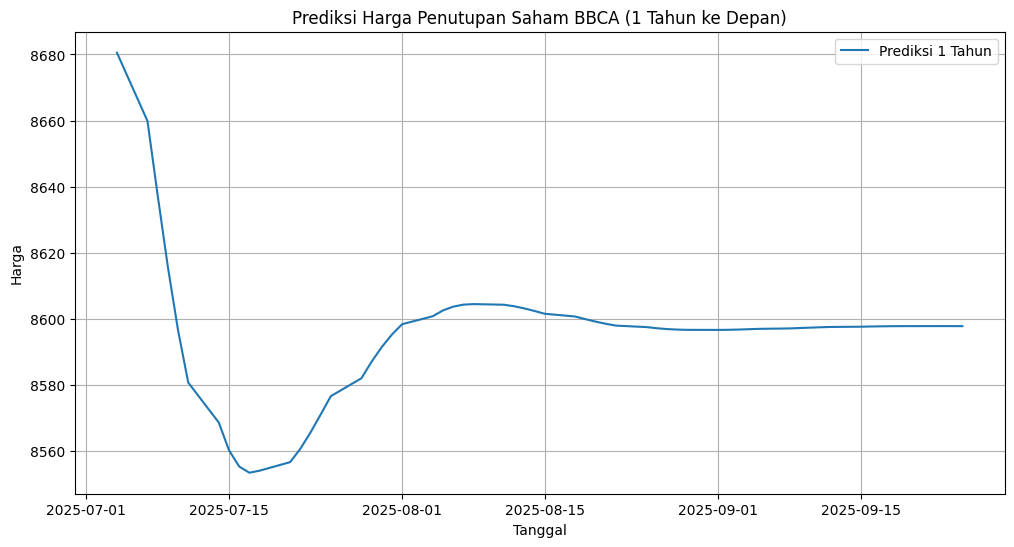

In [ ]:
model = joblib.load('/content/drive/MyDrive/DS/modelBCA.pkl')
def predict_n_days(model, data, scaler, n_days=60, window_size=60):
    predictions = []
    last_window = data[-window_size:]  # Ambil window terakhir

    for _ in range(n_days):
        input_seq = last_window.reshape(1, window_size, data.shape[1])
        pred_scaled = model.predict(input_seq, verbose=0)[0][0]

        # Buat baris baru dengan prediksi dan fitur lainnya
        next_row = last_window[-1].copy()
        next_row[0] = pred_scaled  # ganti nilai Close dengan prediksi

        # Geser window dan tambahkan next_row
        last_window = np.vstack([last_window[1:], next_row])
        predictions.append(pred_scaled)

    # Balik ke harga asli
    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predicted_prices

# Prediksi 1 tahun ke depan (sekitar 60 hari bursa)
future_preds_1yr = predict_n_days(model, scaled_data, scaler_price, n_days=60)

# Buat tanggal masa depan
last_date = df['Date'].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=60, freq='B')  # 'B' = business day

# Buat DataFrame hasil prediksi
future_df_1yr = pd.DataFrame({'Tanggal': future_dates, 'Prediksi Harga': future_preds_1yr.flatten()})

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(future_df_1yr['Tanggal'], future_df_1yr['Prediksi Harga'], label='Prediksi 1 Tahun')
plt.title("Prediksi Harga Penutupan Saham BBCA (1 Tahun ke Depan)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid()
plt.legend()
plt.show()

future_df_1yr.to_csv("/content/drive/MyDrive/DS/prediksi_2_bulan_BCA.csv", index=False)

In [ ]:
dkjfhajkhfjsfjkadjfjkfdhfhldafhjkdhfljkhfljkshjflhkfhjlkfhkjhflkasdhfj